In [48]:
import numpy as np
import pandas as pd

from data_loader import load_names_from_web

import matplotlib.pyplot as plt

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pytrends.request import TrendReq

from datetime import datetime

import requests

## get SSA name data and find some anomalies that occurred since 2004

In [4]:
dfraw = load_names_from_web(category="national", hide_pre_1937=True)
dfraw.sample(5)

,state,year,name,M/F,count
851205,US,1961,Sabra,F,155
1409612,US,1997,Tayton,M,10
534316,US,2011,Kaileena,F,5
1475304,US,1955,Vernice,F,94
1508422,US,1943,Fleta,F,15


In [7]:
dfn1 = dfraw[['name', 'M/F', 'count', 'year']].sort_values(['M/F','name','year'])
dfn1.columns=['name', 'gender', 'count', 'year']
dfn1['diff'] = dfn1.groupby(['gender','name'])['count'].diff()
dfn1['accel'] = dfn1.groupby(['gender','name'])['diff'].diff()
dfn1.head(12)

,name,gender,count,year,diff,accel
529547,Aabha,F,7,2011,NaN,NaN
332735,Aabha,F,5,2012,-2.0,NaN
40723,Aabha,F,9,2014,4.0,6.0
110726,Aabha,F,7,2015,-2.0,-6.0
295685,Aabha,F,7,2016,0.0,2.0
2066820,Aabha,F,6,2019,-1.0,-1.0
1780595,Aabha,F,5,2020,-1.0,0.0
1677182,Aabha,F,5,2021,0.0,1.0
1847356,Aabha,F,5,2022,0.0,0.0
1978085,Aabidah,F,5,2018,NaN,NaN


In [11]:
num_previous_years = 10

dfn2 = dfn1.sort_values(by=['name', 'gender', 'year'])

# note: min_periods=10 means that there won;t be calculations if there are not 10 previous years
# note: shift(1) means the current year is not included ion the average and std dev
dfn2['10yr_ave'] = dfn2.groupby(['name','gender'])['count'].transform(lambda x: x.rolling(window=10, min_periods=10).mean().shift(1))
dfn2['10yr_std'] = dfn2.groupby(['name','gender'])['count'].transform(lambda x: x.rolling(window=10, min_periods=10).std().shift(1))
dfn2['10yr_z_score'] = dfn2['diff'] / dfn2['10yr_std']
dfn2.head()

,name,gender,count,year,diff,accel,10yr_ave,10yr_std,10yr_z_score
448288,Aaban,M,5,2007,NaN,NaN,NaN,NaN,NaN
1658424,Aaban,M,6,2009,1.0,NaN,NaN,NaN,NaN
622298,Aaban,M,9,2010,3.0,2.0,NaN,NaN,NaN
542793,Aaban,M,11,2011,2.0,-1.0,NaN,NaN,NaN
342452,Aaban,M,11,2012,0.0,-2.0,NaN,NaN,NaN


In [14]:
# google trends goes back to 2004
dfn3 = dfn2.loc[dfn2['year']>2003]

In [15]:
z1 = dfn3.sort_values(by=['10yr_z_score']).head(2)
z1['type']='z-score drop'
z2 = dfn3.copy()
z2.replace([np.inf, -np.inf], np.nan, inplace=True)
z2 = z2[~pd.isnull(z2['10yr_z_score'])].sort_values(by=['10yr_z_score']).tail(2)
z2['type']='z-score jump'
z3 = dfn3.sort_values(by=['diff']).head(2)
z3['type']='overall drop'
z4 = dfn3[~pd.isnull(dfn3['diff'])].sort_values(by=['diff']).tail(2)
z4['type']='overafll jump'
anomalies = pd.concat([z1, z2, z3, z4], axis=0)
anomalies

,name,gender,count,year,diff,accel,10yr_ave,10yr_std,10yr_z_score,type
370093,Damon,M,782,2006,-225.0,-240.0,1018.8,22.074621,-10.192701,z-score drop
1769682,Tenzin,F,34,2020,-22.0,-25.0,52.8,2.347576,-9.371370,z-score drop
484603,Jolette,F,258,2005,250.0,248.0,6.8,1.549193,161.374306,z-score jump
2071585,Ermias,M,522,2019,507.0,501.0,7.6,3.098387,163.633546,z-score jump
1797064,Hannah,F,9569,2008,-3749.0,-2517.0,18165.2,3466.793613,-1.081403,overall drop
516209,Isabella,F,19927,2011,-3002.0,-3615.0,16623.6,4450.772747,-0.674490,overall drop
483657,Ava,F,13606,2005,4961.0,2596.0,2598.3,2845.304711,1.743574,overall jump
435944,Jayden,M,15250,2007,5626.0,4266.0,4110.8,3315.270286,1.696996,overall jump


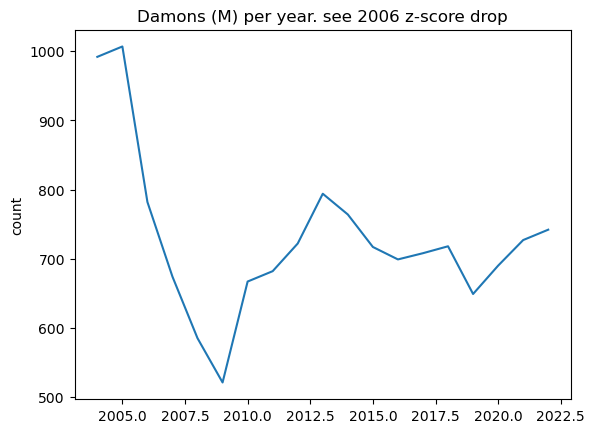

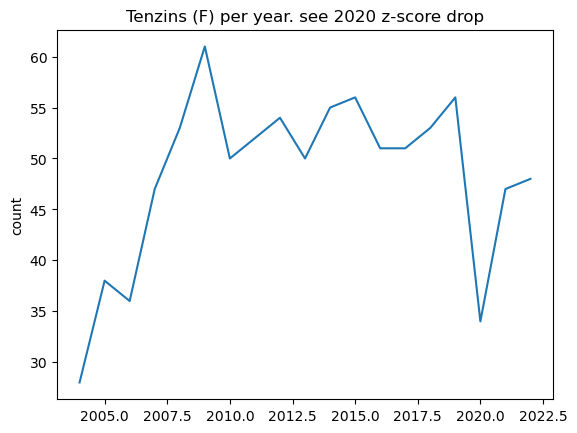

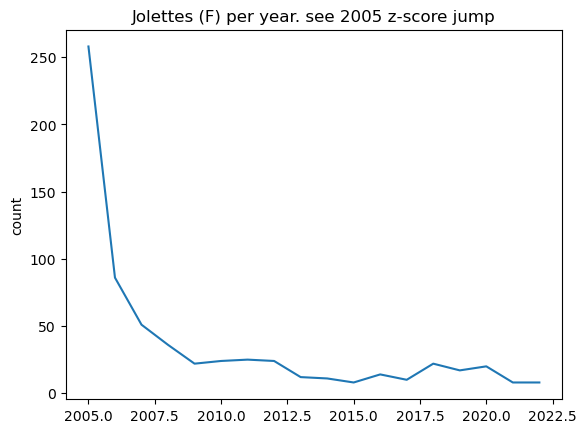

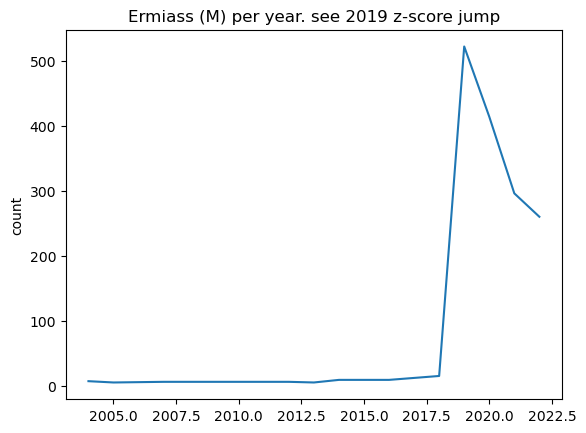

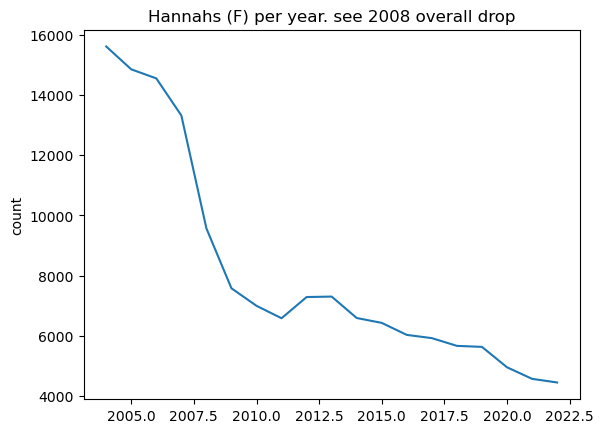

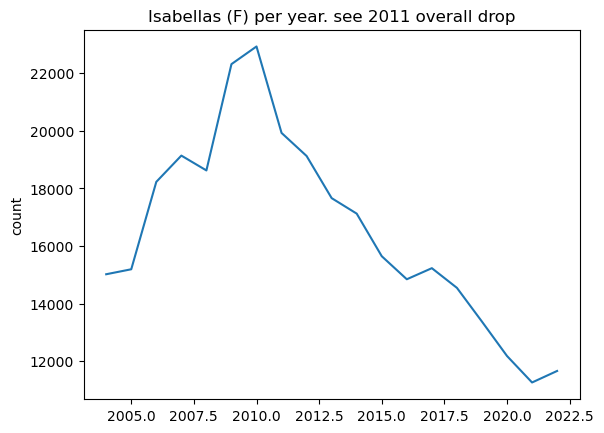

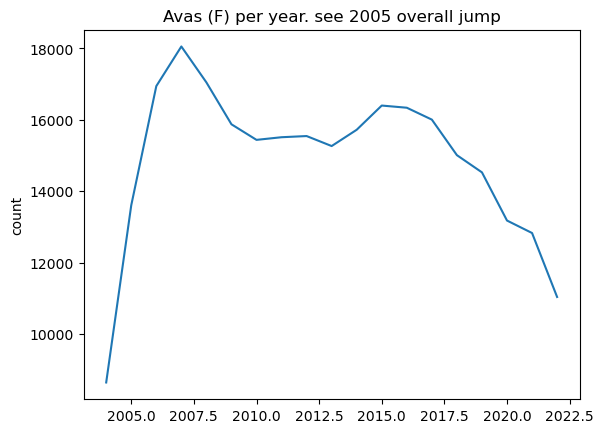

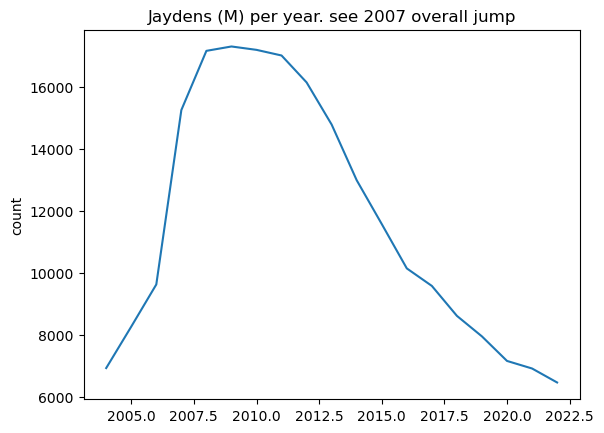

In [18]:
for ind in anomalies.index:
    name = anomalies.name[ind]
    gender = anomalies.gender[ind]
    yr = anomalies.year[ind]
    typ = anomalies.type[ind]
    
    z = dfn3.loc[(dfn3['name']==name) & (dfn3['gender']==gender)].sort_values(['year'])
    plt.plot(z['year'], z['count'])
    plt.ylabel('count')
    plt.title(name + 's (' + gender + ') per year. see ' + str(yr) + ' ' + typ)
    plt.show()    

In [23]:
anomaly_names = list(anomalies['name'])
anomaly_names

['Damon', 'Tenzin', 'Jolette', 'Ermias', 'Hannah', 'Isabella', 'Ava', 'Jayden']

## get some google trends for those names

see https://colab.research.google.com/github/Tanu-N-Prabhu/Python/blob/master/Google_Trends_API.ipynb

install pytrends: 

https://pypi.org/project/pytrends/

In [19]:
# !pip install pytrends

In [90]:
session = requests.Session()
session.get('https://trends.google.com')
cookies_map = session.cookies.get_dict()
nid_cookie = cookies_map['NID']

In [91]:
# keywords = anomaly_names
keywords = ['Jayden']
geo = 'US'
timeframe = '2005-01-01 ' + datetime.now().strftime('%Y-%m-%d')  # just a string represenmting date range
gprop = ''  # Google property: empty means search; could be 'images', 'news', etc.

In [92]:
pytrend = TrendReq(requests_args={'headers': {'Cookie': f'NID={nid_cookie}'}})

In [93]:
pytrend.build_payload(kw_list=keywords, geo=geo, timeframe=timeframe, gprop=gprop)

In [94]:
# FYI: Interest by Region (state)
# region_data = pytrend.interest_by_region()
# region_data.head(10)

In [95]:
trends_data = pytrend.interest_over_time()

TooManyRequestsError: The request failed: Google returned a response with code 429

In [ ]:
trends_data.head()

In [75]:
jolette_monthly = pd.read_csv('Jolette.csv', header=1)
jolette_monthly.columns=['month', 'jolette']
jolette_monthly.head()

,month,jolette
0,2004-01,0
1,2004-02,0
2,2004-03,0
3,2004-04,56
4,2004-05,0


In [77]:
# trends_data['year'] = trends_data['date'].dt.to_period('Y')
jolette_monthly['year'] = pd.to_datetime(jolette_monthly['month']).dt.year
jolette_monthly.head()

,month,jolette,year
0,2004-01,0,2004
1,2004-02,0,2004
2,2004-03,0,2004
3,2004-04,56,2004
4,2004-05,0,2004


In [78]:
jolette_yearly = jolette_monthly.groupby('year')['jolette'].sum().reset_index()
jolette_yearly.head()

,year,jolette
0,2004,56
1,2005,297
2,2006,46
3,2007,26
4,2008,50


In [82]:
name = 'Jolette'
gender = 'F'
    
z1 = dfn3.loc[(dfn3['name']==name) & (dfn3['gender']==gender)].sort_values(['year'])
z1.head()

,name,gender,count,year,diff,accel,10yr_ave,10yr_std,10yr_z_score
484603,Jolette,F,258,2005,250.0,248.0,6.8,1.549193,161.374306
351887,Jolette,F,86,2006,-172.0,-422.0,31.6,79.555990,-2.161999
418657,Jolette,F,51,2007,-35.0,137.0,39.6,80.709630,-0.433653
1801353,Jolette,F,36,2008,-15.0,20.0,44.2,79.824530,-0.187912
1633434,Jolette,F,22,2009,-14.0,1.0,47.1,78.843657,-0.177567


In [86]:
z2 = pd.merge(jolette_yearly, z1, on=['year'])
z2.head()

,year,jolette,name,gender,count,diff,accel,10yr_ave,10yr_std,10yr_z_score
0,2005,297,Jolette,F,258,250.0,248.0,6.8,1.549193,161.374306
1,2006,46,Jolette,F,86,-172.0,-422.0,31.6,79.555990,-2.161999
2,2007,26,Jolette,F,51,-35.0,137.0,39.6,80.709630,-0.433653
3,2008,50,Jolette,F,36,-15.0,20.0,44.2,79.824530,-0.187912
4,2009,59,Jolette,F,22,-14.0,1.0,47.1,78.843657,-0.177567


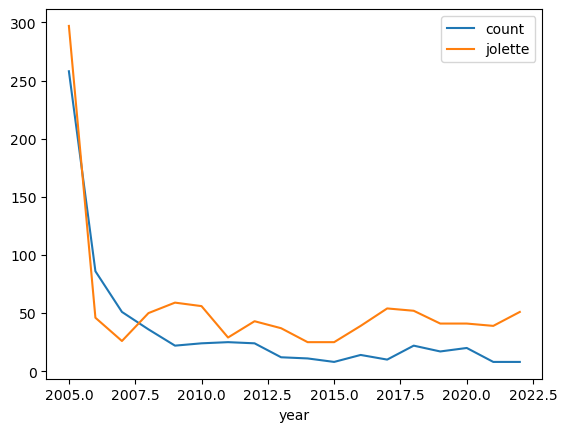

In [89]:
z2.plot(x='year', y=['count', 'jolette'])
plt.show()    